# Chebyshev Derivatives with DCT Variants

Based on my [experiments with the various DCT types](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/dct_types_comparison.ipynb) it seems like the DCT-II/III pair can better reconstruct a function with [fewer coefficients](https://dsp.stackexchange.com/questions/96172/why-does-the-dct-ii-have-better-energy-compaction-than-dct-i), which may be why it's the default DCT and the one used in commonplace compression algorithms.

It's natural to then wonder whether we could better represent functions with this other set of cosines and take derivatives with improved fidelity, even though it's not the variant that falls out of [the math](https://pavelkomarov.com/spectral-derivatives/math.pdf). So I've spent a while trying to [work it out](https://github.com/pavelkomarov/spectral-derivatives/issues/13).

In [1]:
import numpy as np
from scipy.fft import dct, dst
from matplotlib import pyplot

## A Minimal Example

Let's avert the need for the variable transfrom from $\theta$ to $x$ and simply work in the $\theta$ domain. The DCT is equivalent to a DFT on an O(half)-length vector (I say O as in order, because the exact value of $M$ varies type-to-type), so we only need to worry about the domain $\theta \in [0, \pi]$.

In [2]:
N = 6
th = np.linspace(0, np.pi, 100)

We'll define a function that's *even* on $[0, 2\pi)$, so we can take its 1st derivative (the simplest choice), which will be *odd* on the same interval.

In [3]:
y = lambda th: np.cos(3*th) + 3*np.cos(5*th) # even function, only cosines so the DCT can truly capture it
dy = lambda th: -3*np.sin(3*th) - 15*np.sin(5*th) # odd function, analytic, known derivative
d2y = lambda th: -9*np.cos(3*th) - 75*np.cos(5*th)

## Derivatives with DCT-I/DST-I

To ground ourselves in what we know works, let's do the type I case.

$$
\begin{align*}
y_n &= \frac{1}{M} \Big( \underbrace{Y_0 + Y_N (-1)^n + 2 \sum_{k=1}^{N-1} Y_k \cos(\frac{\pi nk}{N})}_{\text{DCT-I}} \Big) \\
y_n^{(\text{odd } \nu)} &= \frac{1}{M} \underbrace{2 \sum_{k=1}^{N-1} j (jk)^\nu Y_k \sin(\frac{\pi nk}{N})}_{\text{DST-I}} \\
y_n^{(\text{even } \nu)} &= \frac{1}{M} \Big( \underbrace{(j0)^\nu Y_0 + (jN)^\nu Y_N (-1)^n + 2 \sum_{k=1}^{N-1} (jk)^\nu Y_k \cos(\frac{\pi nk}{N})}_{\text{DCT-I}} \Big)
\end{align*}
$$

Notice we're sampling at:

$$\theta_{n1} = \frac{\pi}{N}n$$

And the implicit vector underlying [a DFT equivalent to type-I](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/dft_dct_dst_relationship.ipynb) has indices:

$$[0, 1, ... N-1, N, N-1, ... 1]$$

which has length $M = 2N$.

## DCT-I/DST-I on the Example

L1 dy: 1.4210854715202004e-14
L1 d2y: 7.815970093361102e-14


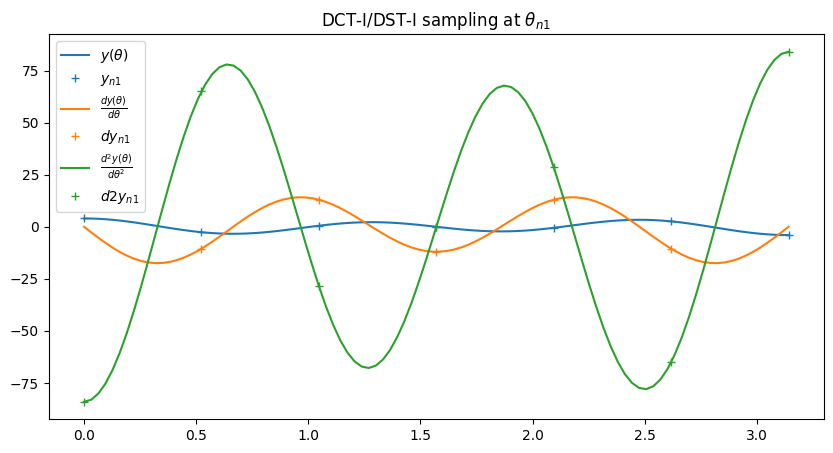

In [4]:
M = 2*N
k = np.arange(N+1); k[-1] = 0 # We zero out the Nyquist term, M/2 = N, corresponding to Y_N

th_n1 = np.linspace(0, np.pi, N+1, endpoint=True) # INCLUDE the endpoint, because [0, ... N]

y_n1 = y(th_n1)
Y_k = dct(y_n1, 1)
Y_p = -k * Y_k # j * (jk) * Y_k
dy_n1 = dst(Y_p[1:-1], 1)/M # The DST-I definition takes only the central (nonzero) part of Y_p
Y_p = -k**2 * Y_k # (jk)**2 * Y_k
d2y_n1 = dct(Y_p, 1)/M # DCT-III

print("L1 dy:", np.max(np.abs(dy_n1 - dy(th_n1)[1:-1]))) # compare against analytic answers
print("L1 d2y:", np.max(np.abs(d2y_n1 - d2y(th_n1))))

pyplot.figure(figsize=(10,5))
pyplot.plot(th, y(th), label=r"$y(\theta)$")
pyplot.plot(th_n1, y_n1, 'C0+', label=r"$y_{n1}$")
pyplot.plot(th, dy(th), label=r"$\frac{dy(\theta)}{d\theta}$")
pyplot.plot(th_n1[1:-1], dy_n1, 'C1+', label=r"$dy_{n1}$")
pyplot.plot(th, d2y(th), label=r"$\frac{d^2y(\theta)}{d\theta^2}$")
pyplot.plot(th_n1, d2y_n1, 'C2+', label=r"$d2y_{n1}$")
pyplot.title(r"DCT-I/DST-I sampling at $\theta_{n1}$")
pyplot.legend();

The numerically-found derivative matches the analytic truth *perfectly*, and the answes still fall on the $\theta_{n1}$ samples, but the endpoints are missing for the DST-I. This turns out to not be such a problem, though, because when variable transforming back to $x$ from $\theta$ we have to find domain endpoints by [L'Hôpital's rule anyway](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/chebyshev_domain_endpoints.ipynb).

## Derivatives with DCT-II,III and DST-III

If we transform to frequency domain with type II, then implicitly we're assuming the data is coming [from half-index points](https://github.com/pavelkomarov/spectral-derivatives/issues/13), $\theta_{n2} = \frac{\pi}{N+1} (n + \frac{1}{2})$, and being transformed to whole number index points (wavenumbers in this case). The natural inverses are type III, which assume we're going from whole number index points back the original half-index sample points.

$$
\begin{align*}
Y_k &= \underbrace{2 \sum_{n=0}^N y_n \cos\Big(\frac{\pi k}{N + 1}(n + \frac{1}{2})\Big)}_{\text{DCT-II}}\\
y_n & = \frac{1}{M} \Big( \underbrace{Y_0 + 2 \sum_{k=1}^N Y_k \cos\Big(\frac{\pi k}{N + 1}(n + \frac{1}{2})\Big)}_{\text{DCT-III}} \Big)
\end{align*}
$$

where this time $M = 2(N+1)$, because [the equivalent DFT](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/dft_dct_dst_relationship.ipynb) assumes indices:

$$[0, 1, ... N-1, N, N, N-1, ... 1, 0]$$

If we substitute $\theta_{n2}$ and then consider continuous $\theta$ and take the derivative of $y(\theta)$, similar to the [derivation of the type I case](https://pavelkomarov.com/spectral-derivatives/math.pdf), and then we resample on the same grid, then we get:

$$
\begin{align*}
y_n^{(\text{odd } \nu)} &= \frac{1}{M} \Big( \underbrace{\underbrace{(-1)^n}_{\sin\!\big(\frac{\pi (N + 1)}{N+1} (n + \frac{1}{2})\big)} \cdot \underbrace{0}_{Y_{N+1}'} + 2 \sum_{k=1}^{N} Y_k' \sin\!\big(\frac{\pi k}{N+1}(n + \frac{1}{2})\big)}_{\text{DST-III}} \Big)\\
y_n^{(\text{even } \nu)} &= \frac{1}{M} \Big( \underbrace{\underbrace{0}_{Y_0'} + 2 \sum_{k=1}^N Y_k' \cos\Big(\frac{\pi k}{N + 1}(n + \frac{1}{2})\Big)}_{\text{DCT-III}} \Big)
\end{align*}
$$

For the DST case, [this stackoverflow post](https://stackoverflow.com/questions/57675927/how-to-calculate-spectral-derivative-using-scipy-fftpack-dst-dct) was really helpful.

### Visualizing the Different $\theta_n$ Samplings

It's helpful to look at $\theta_{n1}$ and $\theta_{n2}$ visually.

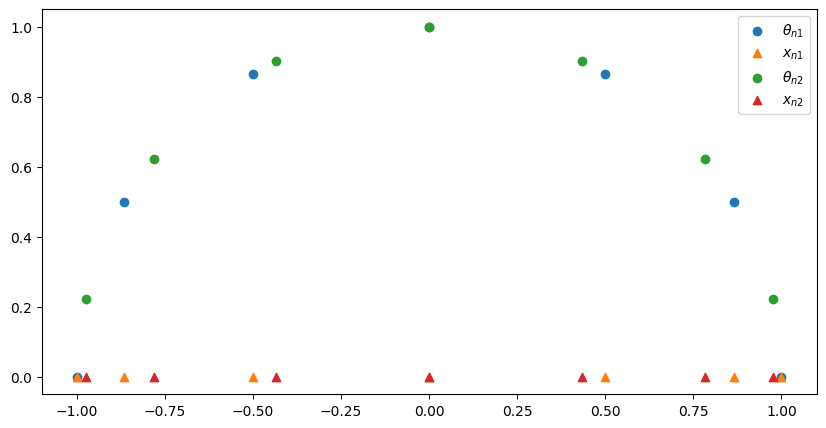

In [5]:
th_n2 = np.pi/(N+1) * (np.arange(N+1) + 0.5) # Sample from half-indices. At n = 0 we're already at 1/2 a step.

pyplot.figure(figsize=(10,5))
pyplot.scatter(np.cos(th_n1), np.sin(th_n1), label=r"$\theta_{n1}$")
pyplot.scatter(np.cos(th_n1), [0 for i in range(len(th_n1))], label=r"$x_{n1}$", marker='^')
pyplot.scatter(np.cos(th_n2), np.sin(th_n2), label=r"$\theta_{n2}$")
pyplot.scatter(np.cos(th_n2), [0 for i in range(len(th_n2))], label=r"$x_{n2}$", marker='^')
pyplot.legend();

Notice the type-II sampling doesn't get all the way to the edges of the domain, $[0, \pi]$. The natural exclusion of these points is inconvenient, because we'll need the boundaries if we want to impose boundary conditions. But even in the DCT-I/DST-I case, where the grid naturally includes the edges, they still [have to be treated specially](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/chebyshev_domain_endpoints.ipynb), so perhaps this is no worse.

## DCT-II/DST-III/DCT-III on the Example

L1 dy: 5.329070518200751e-15
L1 d2y: 4.263256414560601e-14


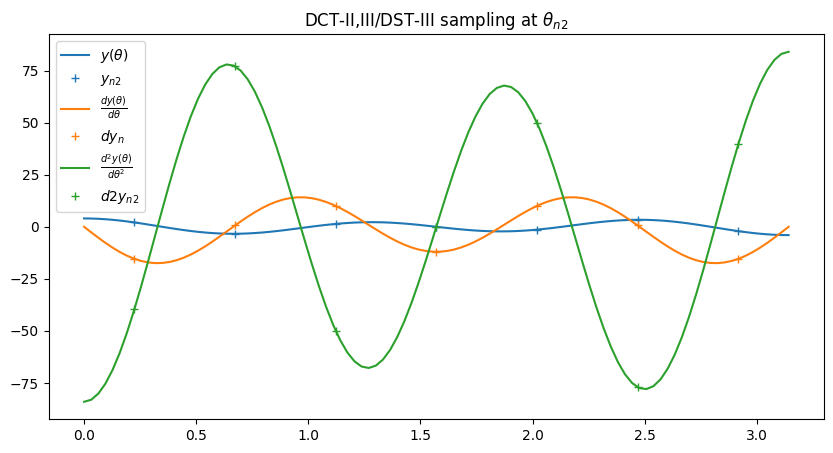

In [6]:
M = 2*(N+1)
k = np.arange(N+1) # This time *don't* zero out the last index, because the Nyquist term would be at N+1

y_n2 = y(th_n2) # Sample at half-index points
Y_k = dct(y_n2, 2)
Y_p = -k * Y_k # j * (jk) * Y_k
Y_p = np.roll(Y_p, -1) # shift to left
dy_n2 = dst(Y_p, 3)/M # DST-III
Y_p = -k**2 * Y_k # (jk)**2 * Y_k
d2y_n2 = dct(Y_p, 3)/M # DCT-III

print("L1 dy:", np.max(np.abs(dy_n2 - dy(th_n2))))
print("L1 d2y:", np.max(np.abs(d2y_n2 - d2y(th_n2))))

pyplot.figure(figsize=(10,5))
pyplot.plot(th, y(th), label=r"$y(\theta)$")
pyplot.plot(th_n2, y_n2, 'C0+', label=r"$y_{n2}$")
pyplot.plot(th, dy(th), label=r"$\frac{dy(\theta)}{d\theta}$")
pyplot.plot(th_n2, dy_n2, 'C1+', label=r"$dy_{n}$")
pyplot.plot(th, d2y(th), label=r"$\frac{d^2y(\theta)}{d\theta^2}$")
pyplot.plot(th_n2, d2y_n2, 'C2+', label=r"$d2y_{n2}$")
pyplot.title(r"DCT-II,III/DST-III sampling at $\theta_{n2}$")
pyplot.legend();

## Why Mixing Samplings Doesn't Work 

A natural thing to try if we want to get the domain edges back is to see what happens when we use $\theta_{n1}$ with the II/III transforms:

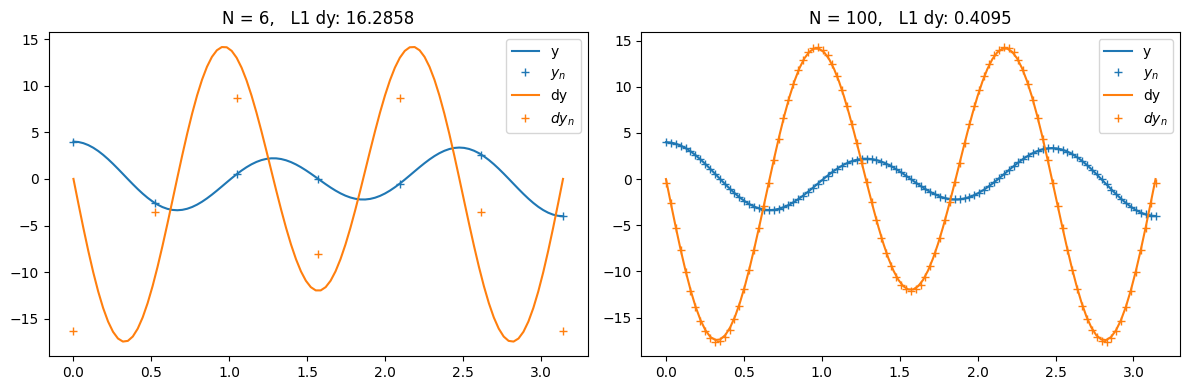

In [7]:
fig, axes = pyplot.subplots(1, 2, figsize=(12,4))

for i,N_ in enumerate([N, 100]):
    M_ = 2*(N_+1)
    th_n_ = np.linspace(0, np.pi, N_+1, endpoint=True) # like th_n1
    k_ = np.arange(N_+1)
    
    y_n_ = y(th_n_)
    Y_k = dct(y_n_, 2) # DCT-II with th_n1 sampling
    Y_p = -k_ * Y_k # j * (jk) * Y_k
    Y_p = np.roll(Y_p, -1) # shift to left
    dy_n_ = dst(Y_p, 3)/M_

    axes[i].plot(th, y(th), label="y")
    axes[i].plot(th_n_, y_n_, 'C0+', label=r"$y_n$")
    axes[i].plot(th, dy(th), label="dy")
    axes[i].plot(th_n_, dy_n_, 'C1+', label="$dy_n$")
    axes[i].legend()
    axes[i].set_title(f"N = {N_},   L1 dy: {np.max(np.abs(dy_n_ - dy(th_n_))):.4f}")
pyplot.tight_layout()

Those errors are much too high. What's going on here?

### Horizontal Compression

If we sample the function at $\theta_{n1}$, which covers $[0, \pi]$, but then use the II/III transforms, the transforms still assume the data is coming from points $\theta_{n2}$, which covers the interval $[\frac{\pi}{2(N+1)}, \frac{\pi (2N+1)}{2(N+1)}]$. This *compresses* the function slightly, by a factor of $\frac{N}{N+1}$. 

To see this as clearly as possible, let's define a new, simpler function:

$$
\begin{align*}
y_1(\theta) &= \cos(2\theta)\\
\frac{d}{d\theta}y_1 &= -2\sin(2\theta)
\end{align*}
$$

If we sample this at $\theta_{n1}$ and then use the DCT-II, which assumes the points came from $\theta_{n2}$, it's as if we sampled a higher frequency, phase-shifted version of the function:

$$
\begin{align*}
y_2(\theta) &= \cos\!\big(\frac{N+1}{N} 2(\theta - \frac{\pi}{M})\big)\\
\frac{d}{d\theta}y_2 &= -\frac{N+1}{N} 2 \sin\!\big(\frac{N+1}{N} 2(\theta - \frac{\pi}{M})\big)
\end{align*}
$$

$y_1(\theta_{n1}) = y_2(\theta_{n2})$.

In [8]:
y1 = lambda th: np.cos(2*th)
dy1 = lambda th: -2 * np.sin(2*th)
y2 = lambda th: np.cos((N+1)/N * 2 * (th - np.pi/M))
dy2 = lambda th: -(N+1)/N * 2 * np.sin((N+1)/N * 2 * (th - np.pi/M))

y1_n1 = y1(th_n1)
y2_n2 = y2(th_n2)
assert np.all(np.abs(y1_n1 - y2_n2) < 1e-10) # Sampling y1 at th1 is exactly the same as sampling y2 at th2

Notice $\frac{N}{N+1} \rightarrow 1$ as $N \rightarrow \infty$, which suggests why higher $N$ results in lower error, although still not *no* error. Why?

### Periodic Extension

The DCT is effectively extending the function left and right by *copying* the interval $[0,\pi]$ over and over and then trying to find coefficients for *that*. Because the DCT-I treats the function as symmetric *around the left and right sample points*, the extension of $y_1$ looks like a pure cosine. Contrast this with $y_2$ on $[0,\pi]$, which curls back downward from the peaks at the outermost $\theta_{n2}$ samples. Its extension will actually have cusps! And due to the phase shift of $y_2$, we can't get rid of them.

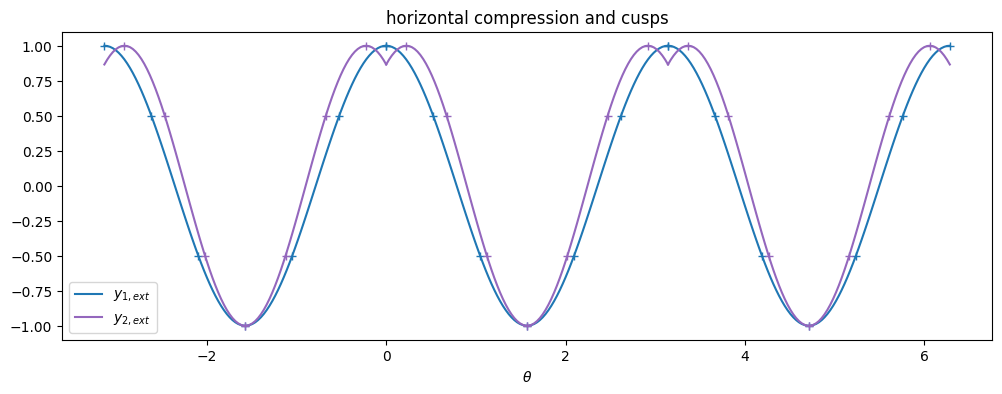

In [9]:
pyplot.figure(figsize=(12,4))
for phi in [0, np.pi, -np.pi]:
    pyplot.plot(th + phi, y1(th), 'C0', label=r"$y_{1,ext}$" if phi==0 else None)
    pyplot.plot(th_n1 + phi, y1_n1, 'C0+')
    pyplot.plot(th + phi, y2(th), 'C4', label=r"$y_{2,ext}$" if phi==0 else None)
    pyplot.plot(th_n2 + phi, y2_n2, 'C4+')
pyplot.title("horizontal compression and cusps")
pyplot.xlabel(r'$\theta$')
pyplot.legend();

### Interpolation Reconstruction

When we try to take a derivative of a sampled function at the sample points, we're really implicitly assuming an interpolation of some kind and then asking what *that interpolation*'s derivative is at the sample points. But the interpolation can have varying fidelity based on how easy the underlying function is to represent. $y_{1,ext}$ is a pure tone, with all its energy in a single coefficient, but $y_{2,ext}$, though still even and therefore representable with cosines, will have its energy spread over *many* more coefficients.

Here is an illustration of what happens when we try to reconstruct. If we do as designed, using a corresponding grid sampling and reconstruction (whether I or II), we match the original function perfectly (left two plots), because the extension is easy to represent. But if we sample at on-index points and treat them like off-index points (right figure), the horizontally compressed function isn't fully captured by the reconstruction. With more samples this phenomenon improves, but it never fully goes away.

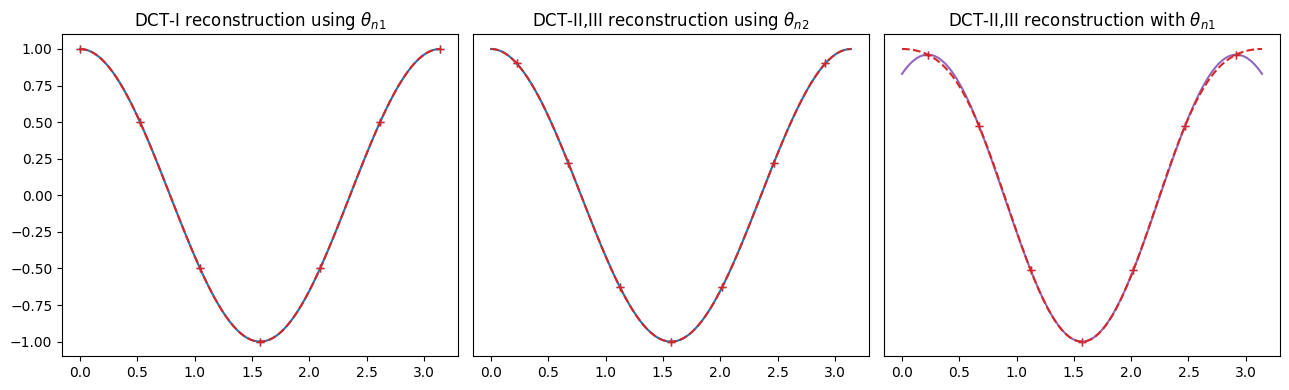

In [10]:
def dct_i_reconstruction(y_n):
    Y_k = dct(y_n, 1)
    y_r = Y_k[0] + Y_k[N]*np.cos(th*N) # (-1)^n = cos(pi*n), pi*n/N = th -> pi*n = th*N
    for k_ in range(1, N):
        y_r += 2*Y_k[k_]*np.cos(th*k_) # continuous th takes the place of th_n = pi*n/N
    y_r /= (2*N)
    return y_r, dct(Y_k, 1)/(2*N)

def dct_ii_reconstruction(y_n):
    Y_k = dct(y_n, 2)
    y_r = Y_k[0]
    dy_r = 0
    for k_ in range(1, N+1):
        y_r += 2*Y_k[k_]*np.cos(k_*th) # th2 = pi * (n + 1/2) / (N+1)
        dy_r -= 2*k_*Y_k[k_]*np.sin(k_*th)
    y_r /= M
    dy_r /= M
    return y_r, dy_r, dct(Y_k, 3)/M

y_r1, y_r1_n = dct_i_reconstruction(y1_n1) # Use the DCT-I to reconstruct y1 from th_n1 sample points 
y1_n2 = y1(th_n2)
y_r2, dy_r2, y_r2_n = dct_ii_reconstruction(y1_n2) # Use the DCT-II to reconstruct y1 from th_n2 sample points
y_r3, dy_r3, y_r3_n = dct_ii_reconstruction(y2_n2) # Use the DCT-II to try to reconstruct y2 from th_n2 sample points

fig, axes = pyplot.subplots(1, 3, figsize=(13,4))
axes[0].plot(th, y1(th))
axes[0].plot(th_n1, y1_n1, 'C0+')
axes[0].plot(th, y_r1, 'C3--')
axes[0].plot(th_n1, y_r1_n, 'C3+')
axes[0].set_title(r"DCT-I reconstruction using $\theta_{n1}$")
axes[1].plot(th, y1(th), label="y2")
axes[1].plot(th_n2, y1_n2, 'C0+')
axes[1].plot(th, y_r2, 'C3--')
axes[1].plot(th_n2, y_r2_n, 'C3+')
axes[1].set_yticks([])
axes[1].set_title(r"DCT-II,III reconstruction using $\theta_{n2}$");
axes[2].plot(th, y2(th), 'C4')
axes[2].plot(th_n2, y2_n2, 'C4+')
axes[2].plot(th, y_r3, 'C3--')
axes[2].plot(th_n2, y_r3_n, 'C3+')
axes[2].set_yticks([])
axes[2].set_title(r"DCT-II,III reconstruction with $\theta_{n1}$");
pyplot.tight_layout()

### Derivatives of Interpolation

If we now try to take derivatives, we can first observe that the horizontal squash of $y_2$ versus $y_1$ will scale the derivative by a factor of $\frac{N+1}{N}$, but correcting for this alone is insufficient, because the *shape* of the reconstruction doesn't fit $y_2$ perfectly, not even on the interval $[\frac{\pi}{M}, \frac{2(N+1)}{M}]$ between the first and last samples.

If we go through the spectral derivative flow and plot against the actual interpolation's derivative, then we can see they align, that this is where the incorrect derivative samples are coming from. Basically, the mismatch between $y_2$ and its reconstruction, which is essentially zero *at* the sample points, becomes amplified everywhere in the derivative. This the problem will only get worse for higher derivatives.

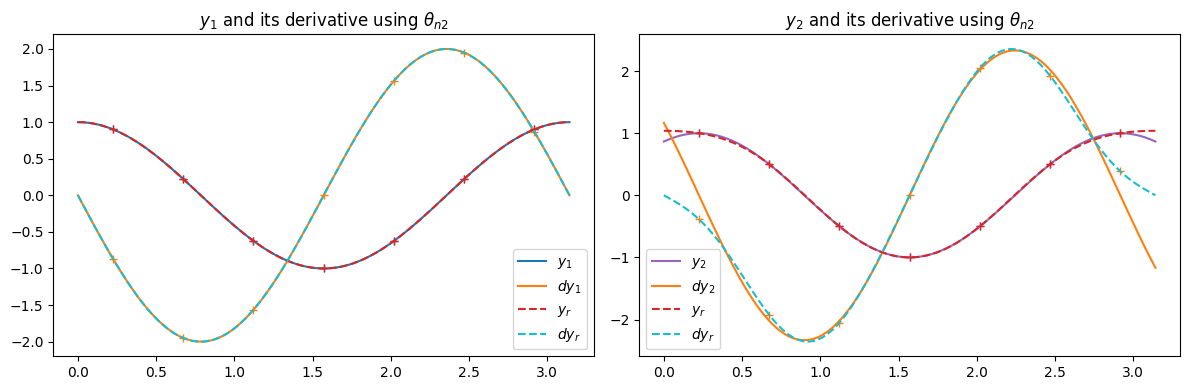

In [11]:
Y_k = dct(y1_n2, 2)
Y_p = -k * Y_k # j * (jk) * Y_k
Y_p = np.roll(Y_p, -1) # shift to left
dy1_n2 = dst(Y_p, 3)/M

fig, axes = pyplot.subplots(1, 2, figsize=(12,4))
axes[0].plot(th, y1(th), label=r"$y_1$")
axes[0].plot(th_n2, y1_n2, 'C0+')
axes[0].plot(th, dy1(th), label=r"$dy_1$")
axes[0].plot(th_n2, dy1_n2, 'C1+')
axes[0].plot(th, y_r2, 'C3--', label=r"$y_r$")
axes[0].plot(th_n2, y_r2_n, 'C3+')
axes[0].plot(th, dy_r2, 'C9--', label=r"$dy_r$")
axes[0].set_title(r"$y_1$ and its derivative using $\theta_{n2}$")
axes[0].legend()

Y_k = dct(y2_n2, 2) # = dct(y1_n1, 2), DCT-II of y1 with th_n1 sampling
Y_p = -k * Y_k # j * (jk) * Y_k
Y_p = np.roll(Y_p, -1) # shift to left
dy1_n1 = dst(Y_p, 3)/M

axes[1].plot(th, y2(th), 'C4', label=r"$y_2$")
axes[1].plot(th_n2, y2_n2, 'C4+')
axes[1].plot(th, dy2(th), 'C1', label=r"$dy_2$")
axes[1].plot(th_n2, dy1_n1, 'C1+')
axes[1].plot(th, y_r3, 'C3--', label=r"$y_r$")
axes[1].plot(th_n2, y_r3_n, 'C3+')
axes[1].plot(th, dy_r3, 'C9--', label=r"$dy_r$")
axes[1].set_title(r"$y_2$ and its derivative using $\theta_{n2}$")
axes[1].legend()
pyplot.tight_layout()

### Conclusion

The Chebyshev polynomials correspond to the shadows of [integer wavenumber cosines](https://pavelkomarov.com/spectral-derivatives/math.pdf) over the domain $[0, \pi]$. The DCT-I fundamentally assumes $\theta = 0$ happens at $n = 0$ and that $\theta = \pi$ happens at $n = N$, and the DCT-II fundamentally assumes $\theta = 0$ happens at $n = -\frac{1}{2}$ and $\theta = \pi$ happens at $n = N + \frac{1}{2}$.

This coupled with the interpolation mismatches above shows that in order to use the DCT-II/III transforms, we can't get around needing to sample on $\theta_{n2}$ points.